In [ ]:
# pip install alphagens==0.3.2
# 然后去github网站上把那个数据下载下来

In [1]:
import pandas as pd
import numpy as np
import joblib # >= 1.2.0
import matplotlib.pyplot as plt
import os


In [2]:
from alphagens.factor_utils import compute_forward_returns, get_clean_factor, get_clean_factor_and_forward_returns
from alphagens.backtest import QuickBackTestor, QuickFactorTestor
from alphagens.utils.metrics import FactorMetrics, StrategyMetrics
from alphagens.data_source.tushare import pro, Stock, Index
from alphagens.calendars import DEFAULT_CALENDAR
import joblib
from alphagens.utils.format_output import df_to_html

In [3]:
class Context:
    DATA_PATH = "./data"
    START_DATE = "20100101"
    END_DATE = "20180101"
    BENCHMARK = "000300.SH"
    
    trade_dates = DEFAULT_CALENDAR.sessions_in_range(START_DATE, END_DATE)
    REBALANCE_DATES = DEFAULT_CALENDAR.Monthly(trade_dates)

In [4]:
class DataPortal:

    def __init__(self):
        self._all_basic_data: pd.DataFrame = joblib.load(f"{Context.DATA_PATH}/tushare.ex_basic")
        self.prices: pd.DataFrame = self._all_basic_data["close"].unstack().fillna(method='ffill')
        self.universe: list[str] = Index.components(ts_code=Context.BENCHMARK, end_date=Context.END_DATE).index
        self.universe = sorted([x[:-3] for x in self.universe])
    
        self.factors: pd.DataFrame = joblib.load(f"{Context.DATA_PATH}/uqer.factor").loc[Context.trade_dates]
        self.industry_map: pd.Series = joblib.load(f"{Context.DATA_PATH}/uqer.industry_map")

    def history(self, date, symbols: list, field: str, lookback: int = None):
        if lookback is not None:
            slice_dates = DEFAULT_CALENDAR.history(date, lookback)
            return self._all_basic_data.loc[(slice_dates, symbols), field]

    def query_covariance(self, date, symbols, lookback):
        """请注意协方差矩阵的数量级!!!
        """
        if lookback < 2 * len(symbols):
            raise ValueError("lookback must be twice as long as length of symbols")
        slice_data = self.history(date, symbols, "pct_chg", lookback) / 100
        slice_data = slice_data.unstack().fillna(0)
        mean = slice_data.mean(axis=0)
        cov = slice_data.cov()
        return mean, cov
    
    @property
    def factor_names(self):
        return self.factors.columns.to_list()
    
    def factor_get(self, factor_name, dates=None):
        assert factor_name in self.factor_names
        if dates is not None:
            return self.factors.loc[(dates, slice(None)), factor_name]
        else:
            return self.factors[factor_name]

In [5]:
data_portal = DataPortal()

In [6]:
data_portal.factor_get("LCAP").index.get_level_values(0).unique()

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21',
               '2017-12-22', '2017-12-25', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='date', length=1944, freq=None)

In [7]:
integrated_factor = get_clean_factor_and_forward_returns(
    factor=data_portal.factor_get("LCAP", Context.REBALANCE_DATES),
    prices=data_portal.prices,
    groupby=data_portal.industry_map.to_dict(),
    binning_by_group=False,
    quantiles=5,
    periods_by_factor=True,
)

In [8]:
integrated_factor

1T   factor group  factor_quantile
date       asset                                           
2010-01-29 000001  0.034557  24.9337    银行                4
           000002  0.009639  25.3550   房地产                5
           000008  0.152651  20.3798  机械设备                1
           000060  0.033226  23.8638  有色金属                3
           000063  0.062400  25.1308    通信                4
...                     ...      ...   ...              ...
2017-11-30 603160 -0.131828  24.6496    电子                3
           603799 -0.053221  24.6397  有色金属                3
           603833  0.064186  24.5661  轻工制造                3
           603858 -0.069521  24.3414  医药生物                2
           603993 -0.026884  25.7518  有色金属                5

[25166 rows x 4 columns]

In [9]:
data_portal.prices["000001"].loc[Context.REBALANCE_DATES].pct_change()

date
2010-01-29         NaN
2010-02-26    0.034557
2010-03-31    0.033403
2010-04-30   -0.113783
2010-05-31   -0.148343
                ...   
2017-08-31    0.057167
2017-09-29   -0.015066
2017-10-31    0.038697
2017-11-30    0.159447
2017-12-29   -0.005982
Name: 000001, Length: 96, dtype: float64

In [10]:
# 因子测试
model = QuickFactorTestor(Context.START_DATE, Context.END_DATE, data_portal.prices)
evaluator = QuickBackTestor(Context.START_DATE, Context.END_DATE, data_portal.prices)
strategy_positions = model.get_long_short_positions(integrated_factor)
strategy_returns = evaluator.run_backtest(strategy_positions)

<Axes: >

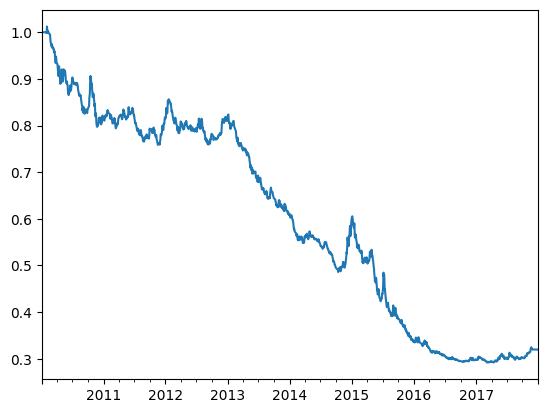

In [11]:
(1 + strategy_returns).cumprod().plot()

In [12]:
StrategyMetrics.annulized_sharpe_ratio(strategy_returns)

-1.4623662306695442

(<Figure size 1200x1000 with 2 Axes>,
 <Axes: title={'center': 'Monthly Returns Heatmap'}, xlabel='Month', ylabel='Year'>)

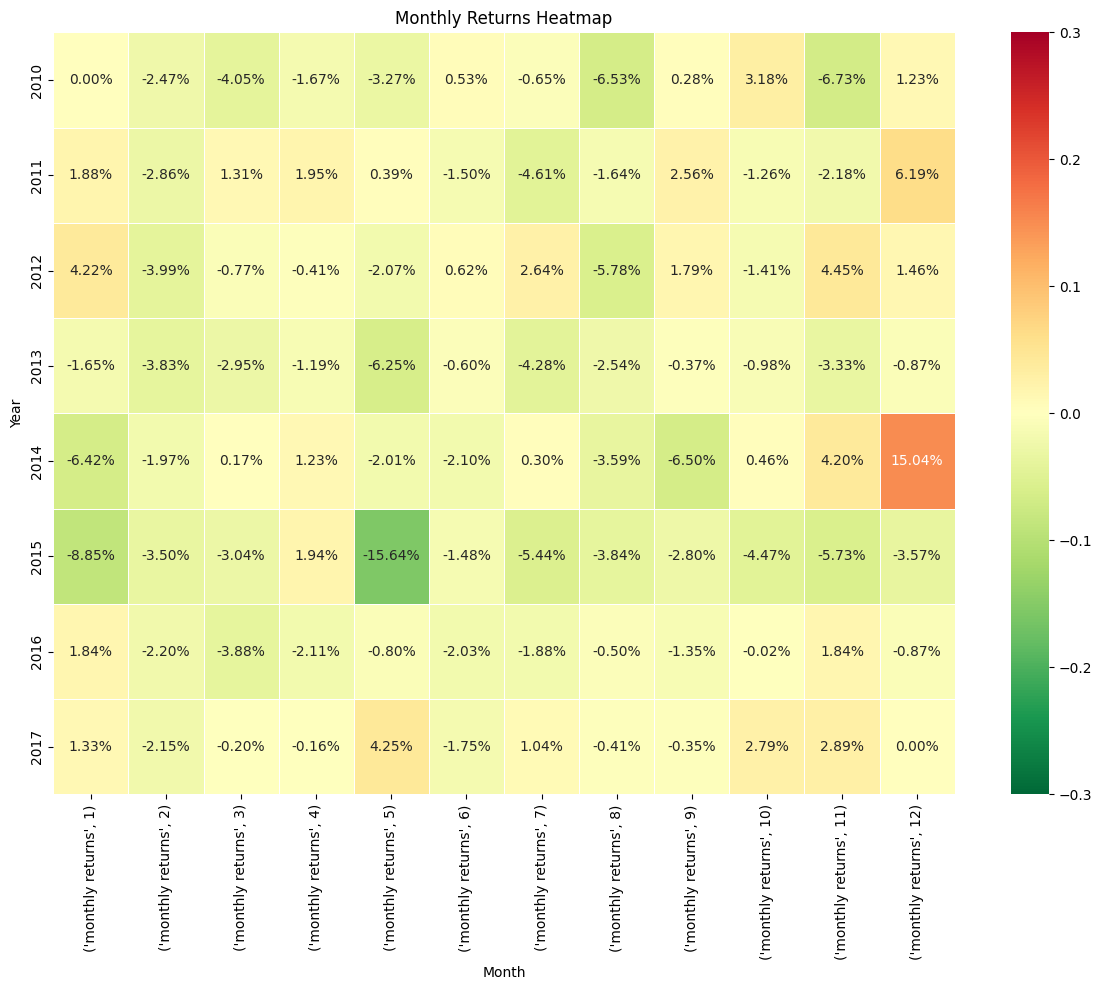

In [13]:
StrategyMetrics.heatmap_of_monthly_returns(strategy_returns)